In [1]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources

openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]



---This notebook have been runed with--- 
Openfisca-france : de25f0ff144607587e92bc977af7c205722ab269 

Commit short SHA: de25
Branch:  master
Date (y/m/d): 2015-10-30 18:51:21  

Openfisca-core : f1bd2fb7f739ee5af6fa5e87034dc8af7139153c  Date: 2015-10-30 18:51:21 


In [1]:
from openfisca_core import reforms
import openfisca_france
from openfisca_france.model.base import *
from numpy import maximum as max_, logical_not as not_, logical_or as or_
from datetime import date

In [2]:
tax_benefit_system = openfisca_france.init_country()()

In [3]:
Reform_individualisation = reforms.make_reform(
    key = 'individualisation',
    name = u'Individualisation du RSA et de l\'IRPP',
    reference = tax_benefit_system,
    )

In [4]:
@Reform_individualisation.formula
class a(SimpleFormulaColumn):
    label = u"always returning 999"
    column = FloatCol
    entity_class = Familles

    def function(self, simulation, period):
        return period, self.zeros() * 999

In [5]:
def modify_legislation_json(reference_legislation_json_copy):
    #reference_legislation_json_copy['children']['xxx']['values'][0]['value'] = 0
    return reference_legislation_json_copy

In [6]:
@Reform_individualisation.formula
class nb_enfant_rsa_indiv(EntityToPersonColumn):
    entity_class = Individus
    label = u"Nombre d'enfants de la famille"
    variable = Familles.column_by_name['nb_enfant_rsa']

In [7]:
@Reform_individualisation.formula
class rsa_eligibilite_tns_indiv(SimpleFormulaColumn):
    # ATTENTION, on a fait le choix de se caler sur les célibataires dans le calcul du plafond,
    # ce qui a pour effet de rendre inéligibles certains couples ou certaines familles avec enfants
    column = BoolCol
    entity_class = Individus
    label = u"Eligibilité au RSA pour un travailleur non salarié"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')

        #tns_benefice_exploitant_agricole_holder = simulation.compute('tns_benefice_exploitant_agricole', period)
        #tns_benefice_exploitant_agricole = self.sum_by_entity(tns_benefice_exploitant_agricole_holder)
        tns_benefice_exploitant_agricole = simulation.calculate('tns_benefice_exploitant_agricole', period) #new
        #tns_employe_holder = simulation.compute('tns_employe', period)
        #tns_employe = self.any_by_roles(tns_employe_holder)
        tns_employe = simulation.calculate('tns_employe', period) #new
        #tns_autres_revenus_chiffre_affaires_holder = simulation.compute('tns_autres_revenus_chiffre_affaires', period)
        #tns_autres_revenus_chiffre_affaires = self.split_by_roles(tns_autres_revenus_chiffre_affaires_holder)
        tns_autres_revenus_chiffre_affaires = simulation.calculate('tns_autres_revenus_chiffre_affaires', period) #new
        #tns_autres_revenus_type_activite_holder = simulation.compute('tns_autres_revenus_type_activite', period)
        #tns_autres_revenus_type_activite = self.split_by_roles(tns_autres_revenus_type_activite_holder)
        tns_autres_revenus_type_activite = simulation.calculate('tns_autres_revenus_type_activite', period) #new
        
        #has_conjoint = simulation.calculate('nb_par', period) > 1
        #nb_enfant_rsa = simulation.calculate('nb_enfant_rsa', period)
        P = simulation.legislation_at(period.start)
        P_agr = P.tns.exploitant_agricole
        P_micro = P.ir.rpns.microentreprise
        maj_2p = P_agr.maj_2p
        maj_1e_2ad = P_agr.maj_1e_2ad
        maj_e_sup = P_agr.maj_e_sup

        #def eligibilite_agricole(has_conjoint, nb_enfant_rsa, tns_benefice_exploitant_agricole, P_agr):
        def eligibilite_agricole(tns_benefice_exploitant_agricole, P_agr):
            plafond_benefice_agricole = P_agr.plafond_rsa * P.cotsoc.gen.smic_h_b
            #taux_avec_conjoint = 1 + maj_2p + maj_1e_2ad * (nb_enfant_rsa > 0) + maj_e_sup * max_(nb_enfant_rsa - 1, 0)
            #taux_sans_conjoint = 1 + maj_2p * (nb_enfant_rsa > 0) + maj_e_sup * max_(nb_enfant_rsa - 1, 0)
            #taux_majoration = has_conjoint * taux_avec_conjoint + (1 - has_conjoint) * taux_sans_conjoint
            taux_majoration = 1 #new
            plafond_benefice_agricole_majore = taux_majoration * plafond_benefice_agricole

            return tns_benefice_exploitant_agricole < plafond_benefice_agricole_majore

        def eligibilite_chiffre_affaire(ca, type_activite, P_micro):
            plaf_vente = P_micro.vente.max
            plaf_service = P_micro.servi.max

            return ((type_activite == 0) * (ca <= plaf_vente)) + ((type_activite >= 1) * (ca <= plaf_service))

        eligibilite_agricole = eligibilite_agricole(
       #     has_conjoint, nb_enfant_rsa, tns_benefice_exploitant_agricole, P_agr
            tns_benefice_exploitant_agricole, P_agr
            )
        eligibilite_chiffre_affaire = (
            eligibilite_chiffre_affaire(
       #         tns_autres_revenus_chiffre_affaires[CHEF], tns_autres_revenus_type_activite[CHEF], P_micro
                tns_autres_revenus_chiffre_affaires, tns_autres_revenus_type_activite, P_micro #new
            ) *
            eligibilite_chiffre_affaire(
       #         tns_autres_revenus_chiffre_affaires[PART], tns_autres_revenus_type_activite[PART], P_micro
                tns_autres_revenus_chiffre_affaires, tns_autres_revenus_type_activite, P_micro #new
            )
        )

        return period, eligibilite_agricole * (1 - tns_employe) * eligibilite_chiffre_affaire


In [8]:
@Reform_individualisation.formula
class rsa_eligibilite_indiv(SimpleFormulaColumn):
    # On maintient un calcul en fonction du ménage : règle du RSA pour les moins de 25 ans maintenu (s'ils ont des enfants)
    column = BoolCol
    entity_class = Individus
    label = u"Eligibilité au RSA"

    def function(self, simulation, period):
        period = period.this_month
        #age_holder = simulation.compute('age', period)
        #age_parents = self.split_by_roles(age_holder, roles = [CHEF, PART])
        age = simulation.calculate('age', period) #new
        #activite_holder = simulation.compute('activite', period)
        #activite_parents = self.split_by_roles(activite_holder, roles = [CHEF, PART])
        activite = simulation.calculate('activite', period) #new
        #nb_enfant_rsa = simulation.calculate('nb_enfant_rsa', period)
        nb_enfant_rsa_indiv = simulation.calculate('nb_enfant_rsa_indiv', period)
        rsa_eligibilite_tns_indiv = simulation.calculate('rsa_eligibilite_tns_indiv', period)
        #rsa_condition_nationalite = simulation.compute('rsa_condition_nationalite', period)
        #condition_nationalite = self.any_by_roles(rsa_condition_nationalite, roles = [CHEF, PART])
        condition_nationalite = simulation.calculate('rsa_condition_nationalite', period) #new
        rmi = simulation.legislation_at(period.start).minim.rmi
        #age_min = (nb_enfant_rsa_indiv == 0) * rmi.age_pac
        quifam = simulation.calculate('quifam', period)
        condition_age = or_(age >= rmi.age_pac,  (age < rmi.age_pac) * (quifam == 0) * (nb_enfant_rsa_indiv > 1))
        # ce qui est après le or_ a été codé pour le RSA jeune, mais je ne suis pas sûr du tout que ce soit la vraie règle

        #eligib = (
        #    (age_parents[CHEF] >= age_min) * not_(activite_parents[CHEF] == 2) +
        #    (age_parents[PART] >= age_min) * not_(activite_parents[PART] == 2)
        #)
        
        eligib = condition_age * not_(activite == 2) * (
            condition_nationalite *
            rsa_eligibilite_tns_indiv
            )

        return period, eligib

In [9]:
@Reform_individualisation.formula
class nb_par_indiv(EntityToPersonColumn):
    entity_class = Individus
    label = u"Nombre de parents de la famille"
    variable = Familles.column_by_name['nb_par']

In [10]:
#@Reform_individualisation.formula
#class af_nbenf_indiv(EntityToPersonColumn):
#    entity_class = Individus
#    label = u"Nombre d'enfants de la famille (au sens des allocations familiales)"
#    variable = Familles.column_by_name['af_nbenf']

In [11]:
@Reform_individualisation.formula
class supp_monoparental(SimpleFormulaColumn):
    label = u"Supplément RSA monoparental"
    column = FloatCol
    entity_class = Individus
    
    def function(self, simulation, period):
        quifam = simulation.calculate('quifam', period)
        nb_enfant_rsa_indiv = simulation.calculate('nb_enfant_rsa_indiv', period)
        nb_par_indiv = simulation.calculate('nb_par_indiv', period)
        rmi = simulation.legislation_at(period.start).minim.rmi
        af = simulation.legislation_at(period.start).fam.af
        
        return period, self.zeros() + (quifam == 0) * (nb_par_indiv == 1) * (nb_enfant_rsa_indiv > 0) * (rmi.rmi * rmi.txp2 - af.bmaf * 0.41)

In [12]:
@Reform_individualisation.formula
class aspa_asi_ass_famille(EntityToPersonColumn):
    # Comme on ne pouvait pas individualiser ces trois prestations, on a récupéré les prestations familialisées pour le calcul du RSA individuel
    entity_class = Individus
    label = u"Somme de l'ASPA, ASI et ASS de la famille"
    variable = Familles.column_by_name['br_rmi_ms']

In [13]:
@Reform_individualisation.formula
class rsa_indiv(SimpleFormulaColumn):
    # Concernant les minimas sociaux qui sont déduits du RSA : - minimas sociaux individuels (aah, caah) : pas de problème
    #   - minimas sociaux familialisés (aspa, asi, ass) : on a pris en compte l'allocation familialisée ; il faudrait idéalement les individualiser (mais c'est une autre réforme)
    label = u"RSA individualisé"
    column = FloatCol
    entity_class = Individus
    
    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        eligib = simulation.calculate('rsa_eligibilite_indiv', period)
        ra_rsa_i = simulation.calculate('ra_rsa_i', period)
        br_rmi_i = simulation.calculate('br_rmi_i', period)
        aah = simulation.calculate('aah', period)
        caah = simulation.calculate('caah', period)        
        aspa_asi_ass_famille = simulation.calculate('aspa_asi_ass_famille', period) 
        supp_monoparental = simulation.calculate('supp_monoparental', period)
        rmi = simulation.legislation_at(period.start).minim.rmi
        br_rmi_indiv = br_rmi_i + ra_rsa_i + aspa_asi_ass_famille + aah + caah
        
        return period, self.zeros() + eligib * (supp_monoparental + max_(rmi.rmi - rmi.rmi * rmi.forfait_logement.taux1 - br_rmi_indiv + rmi.pente * ra_rsa_i, 0) )

In [14]:
reform = Reform_individualisation()
reform.modify_legislation_json(modifier_function = modify_legislation_json)

In [15]:
scenario = reform.new_scenario()

In [16]:
scenario.init_single_entity(
    period = 2012,
    parent1 = dict(
        age = 30,
        salaire_de_base = 15000,
        ),
    enfants = [
        dict(age = 10),
        dict(age = 12),
        dict(age = 18),
        ],
    )

In [17]:
reform_simulation = scenario.new_simulation()

In [18]:
reform_simulation.calculate('rsa', "2015-01")

array([ 1006.98272705], dtype=float32)

In [19]:
reform_simulation.calculate('rsa_indiv', "2015-01")

array([ 542.60827637,    0.        ,    0.        ,    0.        ], dtype=float32)

In [20]:
scenario.init_single_entity(
    period = 2015,
    parent1 = dict(
        age = 30,
        salaire_de_base = 0,
        ),
    enfants = [
        dict(birth = date(2005,1,1)),
        dict(birth = date(2005,1,1)),
        ],
    )

In [21]:
reform_simulation2 = scenario.new_simulation()

In [22]:
reform_simulation2.calculate('rsa', "2015-12")

array([ 809.02276611], dtype=float32)

In [23]:
reform_simulation2.calculate('rsa_indiv', "2015-12")

array([ 556.79467773,    0.        ,    0.        ], dtype=float32)

In [24]:
reform_simulation2.calculate('age', "2015-03")

array([45, 10, 10], dtype=int32)

In [25]:
reform_simulation.calculate('rsa_indiv', "2012-12")

array([ 128.5534668,    0.       ,    0.       ,    0.       ], dtype=float32)

# Graphiques

In [26]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from datetime import date  # module nécessaire pour la définition des dates, dont notamment les dates de naissances
from openfisca_france.tests.base import tax_benefit_system




def make_couple_with_child_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = 150000, count = 5000):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 5, #pacsés
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            statmarit = 5,
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation = 4,
            ),
        )
    return scenario
def make_single_with_child_scenario(nombre_enfants = 1, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = 150000, count = 5000):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            birth = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation = 4,
            ),
        )
    return scenario

In [28]:
scenario_monoparental_actuel = make_single_with_child_scenario(1, 2014)

In [29]:
scenario_monoparental_reform = make_single_with_child_scenario(1, 2014, reform)

In [30]:
simulation_monoparental_actuel = scenario_monoparental_actuel.new_simulation()

In [31]:
simulation_monoparental_reform = scenario_monoparental_reform.new_simulation()

In [32]:
salaire_net_actuel = simulation_monoparental_actuel.calculate_add("salaire_net")

In [33]:
salaire_net_reform = simulation_monoparental_reform.calculate_add("salaire_net")

In [37]:
rsa_actuel = simulation_monoparental_actuel.calculate_add("rsa")

In [38]:
rsa_reform = simulation_monoparental_reform.calculate_add("rsa_indiv")

In [34]:
import matplotlib.pyplot as plt

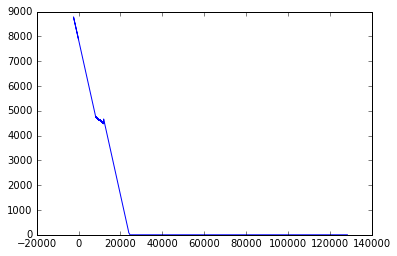

In [39]:
plt.plot(salaire_net_actuel[::2],
        rsa_actuel)

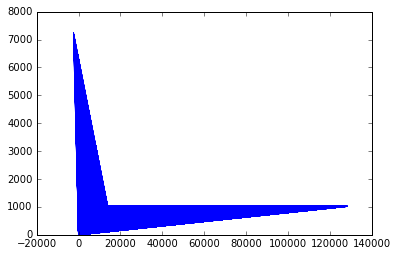

In [50]:
plt.plot(salaire_net_reform,
        rsa_reform)

(0, 300)

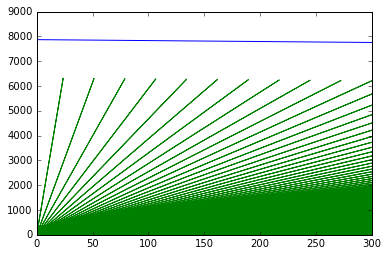

In [55]:
plt.plot(salaire_net_actuel[::2],
        rsa_actuel, salaire_net_reform,
        rsa_reform)
plt.xlim(0,300)

(5000,)